In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, explode, split, trim

In [1]:

# Carpeta donde están los Excel
input_dir = os.path.expanduser("~/BigData_UPAO/Proyecto/DATA_CLINICA")
# Carpeta donde guardar los CSV
output_dir = os.path.expanduser("~/BigData_UPAO/Proyecto/DATA_CLINICA_CSV")
os.makedirs(output_dir, exist_ok=True)

distritos = ["Callayuc", "Choros", "Cujillo", "Cutervo", "LaRamada", "Pimpingos",
             "Querocotillo", "SanAndresdeCutervo", "SanLuisdeLucma", "SanJuandeCutervo",
             "SantaCruz", "SantoDomingodelaCapilla", "SantoTomas", "Socota", "ToribioCasanova"]

for distrito in distritos:
    excel_file = os.path.join(input_dir, f"DATA_{distrito}.xlsx")
    csv_file = os.path.join(output_dir, f"DATA_{distrito}.csv")
    
    if os.path.exists(excel_file):
        print(f"Convirtiendo {distrito} a CSV...")
        df = pd.read_excel(excel_file)
        df.to_csv(csv_file, index=False)
    else:
        print(f"No se encontró archivo para {distrito}")


Convirtiendo Callayuc a CSV...
Convirtiendo Choros a CSV...
Convirtiendo Cujillo a CSV...
Convirtiendo Cutervo a CSV...
Convirtiendo LaRamada a CSV...
Convirtiendo Pimpingos a CSV...
Convirtiendo Querocotillo a CSV...
Convirtiendo SanAndresdeCutervo a CSV...
Convirtiendo SanLuisdeLucma a CSV...
Convirtiendo SanJuandeCutervo a CSV...
Convirtiendo SantaCruz a CSV...
Convirtiendo SantoDomingodelaCapilla a CSV...
Convirtiendo SantoTomas a CSV...
Convirtiendo Socota a CSV...
Convirtiendo ToribioCasanova a CSV...


In [2]:
#Conversion de xlsx a csv archivos generales
import pandas as pd
import os
import glob


input_dir = os.path.expanduser("~/BigData_UPAO/Proyecto/DATA_CLINICA")

output_dir = os.path.expanduser("~/BigData_UPAO/Proyecto/DATA_CLINICA_CSV")
os.makedirs(output_dir, exist_ok=True)


excel_files = glob.glob(os.path.join(input_dir, "*.xlsx"))

for excel_file in excel_files:
    
    base_name = os.path.splitext(os.path.basename(excel_file))[0]
    
    csv_file = os.path.join(output_dir, f"{base_name}.csv")
    
    print(f"Convirtiendo {base_name} a CSV...")
    df = pd.read_excel(excel_file)
    df.to_csv(csv_file, index=False)

print("Conversión completada.")


Convirtiendo DATA_SantaCruz a CSV...
Convirtiendo DATA_Cutervo a CSV...
Convirtiendo DATA_ToribioCasanova a CSV...
Convirtiendo DATA_Pimpingos a CSV...
Convirtiendo DATA_Callayuc a CSV...
Convirtiendo DATA_Choros a CSV...
Convirtiendo DATA_SantoDomingodelaCapilla a CSV...
Convirtiendo DATA_LaRamada a CSV...
Convirtiendo DATA_Socota a CSV...
Convirtiendo DATA_SanLuisdeLucma a CSV...
Convirtiendo DATA_Cujillo a CSV...
Convirtiendo DATA_SanJuandeCutervo a CSV...
Convirtiendo DATA_SanAndresdeCutervo a CSV...
Convirtiendo DATA_Querocotillo a CSV...
Convirtiendo DATA_SantoTomas a CSV...
Conversión completada.


In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("HistoriasClinicas_ETL")
    .getOrCreate()
)

25/11/05 20:27:36 WARN Utils: Your hostname, Debian resolves to a loopback address: 127.0.1.1; using 192.168.64.2 instead (on interface enp0s1)
25/11/05 20:27:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/05 20:27:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql.types import StructType, StructField, StringType


schema = StructType([
    StructField("DNI", StringType(), True),
    StructField("Asegurado", StringType(), True),
    StructField("FecNac", StringType(), True),   
    StructField("SEXO", StringType(), True),
    StructField("CPP", StringType(), True),
    StructField("síntomas", StringType(), True),
    StructField("enfermedad detectada", StringType(), True),
    StructField("Distrito", StringType(), True),
])

In [4]:
distritos = [
    "Callayuc", "Choros", "Cujillo", "Cutervo", "LaRamada", "Pimpingos",
    "Querocotillo", "SanAndresdeCutervo", "SanLuisdeLucma", "SanJuandeCutervo",
    "SantaCruz", "SantoDomingodelaCapilla", "SantoTomas", "Socota", "ToribioCasanova"
]

output_path = "hdfs://localhost:9000/datalake/raw/clinic/historias_csv_unificado/"

dfs = []

for distrito in distritos:
    file_path = f"hdfs://localhost:9000/datalake/raw/clinic/historias_csv/ingestion_date=2025-09-29/distrito={distrito}/*.csv"
    df = spark.read.csv(file_path, header=True, schema=schema)
    dfs.append(df)

In [5]:
from functools import reduce
from pyspark.sql import DataFrame

df_raw = reduce(DataFrame.unionByName, dfs)

In [10]:
from pyspark.sql.functions import trim, upper, col, to_date, concat, lit, substring
df_pre = (
    df_raw
    .withColumn("FecNac", to_date(col("FecNac"), "yyyy-MM-dd"))
    .fillna({"síntomas": "DESCONOCIDOS", "enfermedad detectada": "DESCONOCIDA"})
    .dropDuplicates(["DNI"])
    .withColumn("DNI_masked", concat(lit("XXX-"), substring(col("DNI"), 5, 4)))
    .drop("DNI")
)

In [11]:
df_pre.show(5, truncate=False)
df_pre.printSchema()
print("Total de registros:", df_pre.count())

df_pre.write.mode("overwrite").parquet(output_path)


+--------------------------------+----------+----+---------------------------------------------------------+---------------------------------------+--------------------+---------------------------+----------+
|Asegurado                       |FecNac    |SEXO|CPP                                                      |síntomas                               |enfermedad detectada|Distrito                   |DNI_masked|
+--------------------------------+----------+----+---------------------------------------------------------+---------------------------------------+--------------------+---------------------------+----------+
|NULL                            |NULL      |NULL|NULL                                                     |DESCONOCIDOS                           |DESCONOCIDA         |NULL                       |NULL      |
|Carmen Alberto Cruz Ramírez     |2023-02-20|F   |HUERTILLAS                                               |dolor de cabeza, mareos, visión borrosa|Hipertensión    

Total de registros: 131981


In [12]:
output_path = "hdfs://localhost:9000/datalake/raw/clinic/historias_preprocesadas/"

df_pre.write.mode("overwrite").parquet(output_path)
print("Parquet preprocesado guardado correctamente.")

Parquet preprocesado guardado correctamente.


In [13]:
df_pre.printSchema()

root
 |-- Asegurado: string (nullable = true)
 |-- FecNac: date (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- CPP: string (nullable = true)
 |-- síntomas: string (nullable = false)
 |-- enfermedad detectada: string (nullable = false)
 |-- Distrito: string (nullable = true)
 |-- DNI_masked: string (nullable = true)



In [15]:
df_pre.select("síntomas", "enfermedad detectada").show(10, truncate=False)

[Stage 18:====================================================>   (15 + 1) / 16]

+---------------------------------------+--------------------+
|síntomas                               |enfermedad detectada|
+---------------------------------------+--------------------+
|DESCONOCIDOS                           |DESCONOCIDA         |
|dolor de cabeza, mareos, visión borrosa|Hipertensión        |
|picazón, ojos llorosos                 |Alergia             |
|fiebre                                 |DESCONOCIDA         |
|tos seca, dificultad para respirar     |COVID-19            |
|sensibilidad a la luz, dolor de cabeza |Migraña             |
|micción frecuente, cansancio           |Diabetes            |
|dolor de garganta                      |Asma                |
|DESCONOCIDOS                           |DESCONOCIDA         |
|DESCONOCIDOS                           |DESCONOCIDA         |
+---------------------------------------+--------------------+
only showing top 10 rows



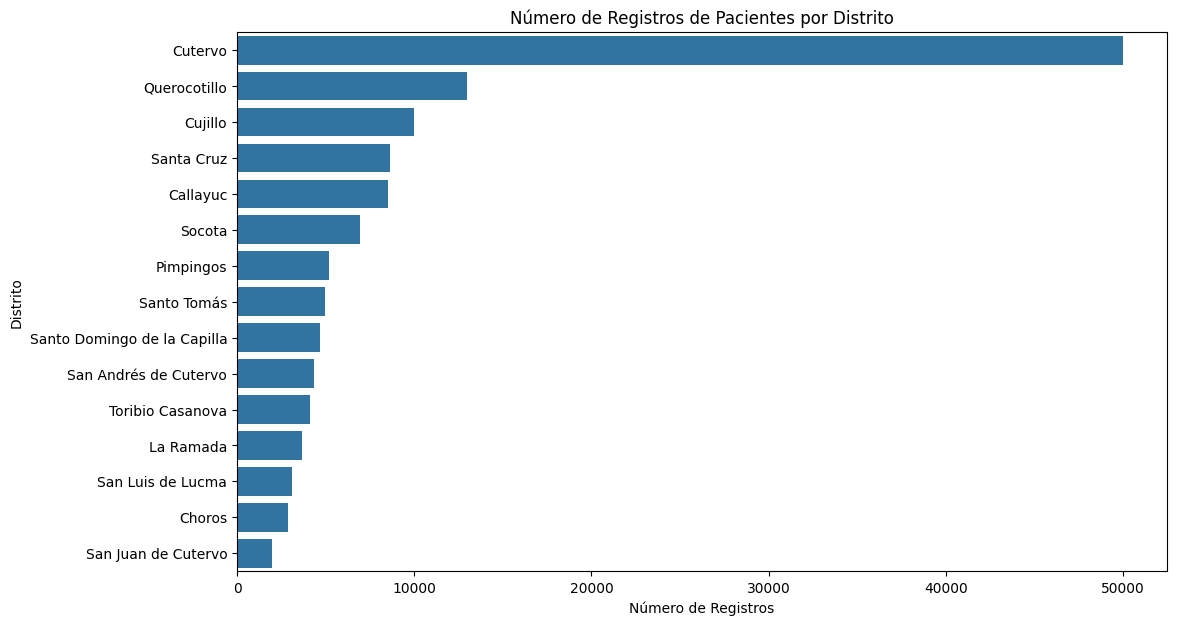

In [16]:



distrito_counts_df = (
    df_pre
    .groupBy("Distrito")
    .count()
    .orderBy(col("count").desc())
)


pd_distrito_counts = distrito_counts_df.toPandas()


plt.figure(figsize=(12, 7))
sns.barplot(data=pd_distrito_counts, x="count", y="Distrito", orient='h')
plt.title("Número de Registros de Pacientes por Distrito")
plt.xlabel("Número de Registros")
plt.ylabel("Distrito")
plt.show()

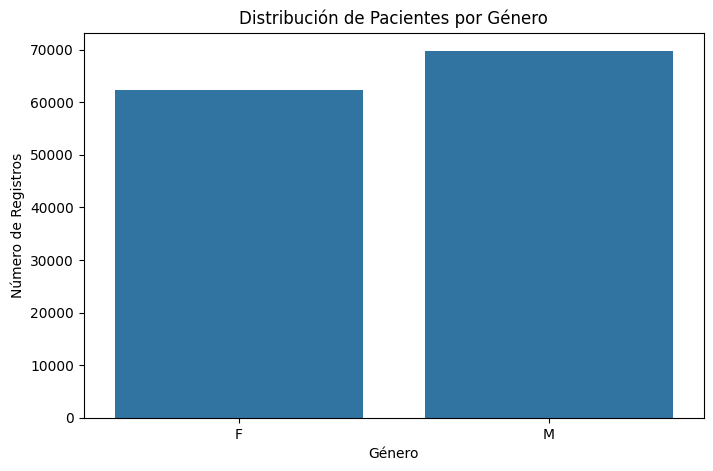

In [17]:

sexo_counts_df = df_pre.groupBy("SEXO").count()


pd_sexo_counts = sexo_counts_df.toPandas()


plt.figure(figsize=(8, 5))
sns.barplot(data=pd_sexo_counts, x="SEXO", y="count")
plt.title("Distribución de Pacientes por Género")
plt.xlabel("Género")
plt.ylabel("Número de Registros")
plt.show()

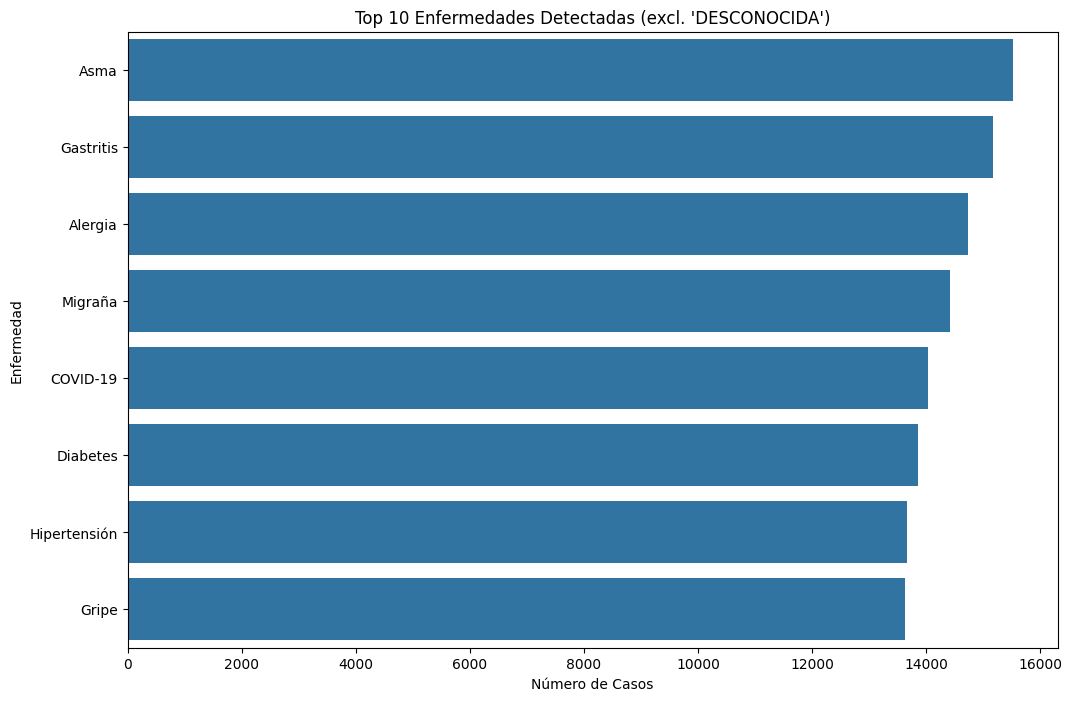

In [18]:

top_enfermedades_df = (
    df_pre
    .filter(col("enfermedad detectada") != "DESCONOCIDA") 
    .groupBy("enfermedad detectada")
    .count()
    .orderBy(col("count").desc())
    .limit(10)  
)


pd_top_enfermedades = top_enfermedades_df.toPandas()


plt.figure(figsize=(12, 8))
sns.barplot(data=pd_top_enfermedades, x="count", y="enfermedad detectada", orient='h')
plt.title("Top 10 Enfermedades Detectadas (excl. 'DESCONOCIDA')")
plt.xlabel("Número de Casos")
plt.ylabel("Enfermedad")
plt.show()

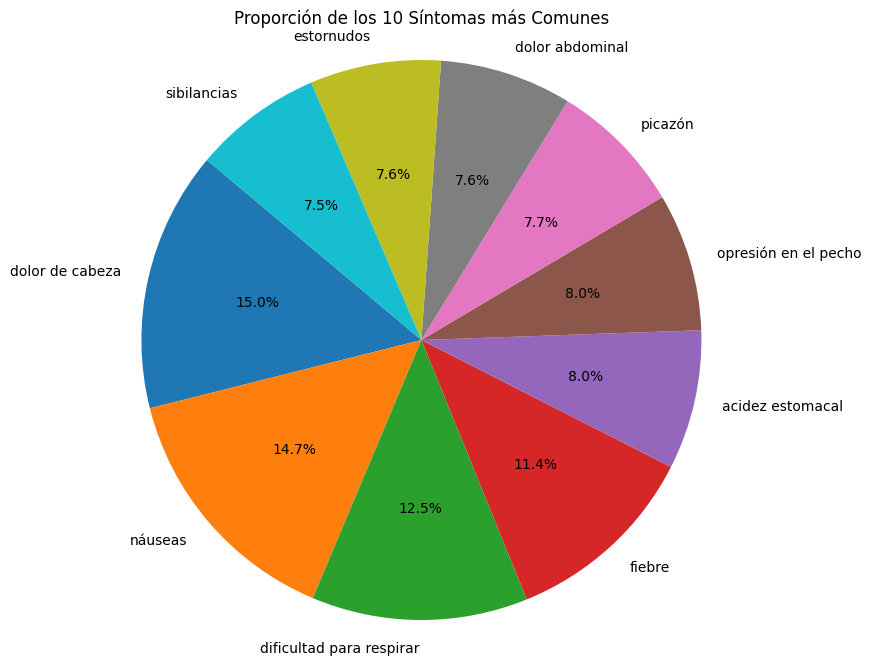

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, explode, split, trim


sintomas_df = (
    df_pre
    .filter(col("síntomas") != "DESCONOCIDOS")
    
    .withColumn("sintomas_array", split(col("síntomas"), ","))
    
    .withColumn("sintoma_individual", explode(col("sintomas_array")))
    
    .withColumn("sintoma_individual", trim(col("sintoma_individual")))
    
    .filter(col("sintoma_individual") != "")
)


top_sintomas_df = (
    sintomas_df
    .groupBy("sintoma_individual")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
)


pd_top_sintomas = top_sintomas_df.toPandas()


plt.figure(figsize=(10, 8))
plt.pie(
    pd_top_sintomas['count'], 
    labels=pd_top_sintomas['sintoma_individual'], 
    autopct='%1.1f%%',  
    startangle=140
)
plt.title("Proporción de los 10 Síntomas más Comunes")
plt.axis('equal')  
plt.show()

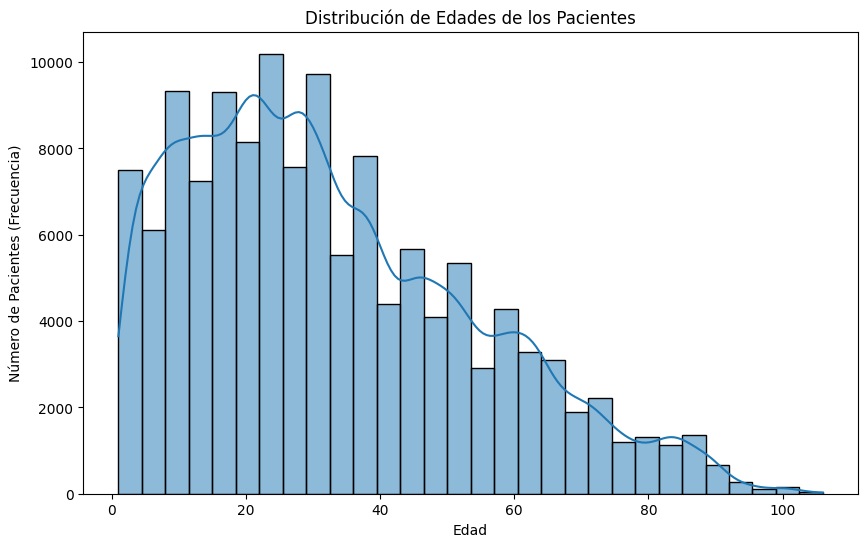

In [20]:
from pyspark.sql.functions import year, current_date


edad_df = (
    df_pre
    .withColumn("Edad", year(current_date()) - year(col("FecNac")))
    
    .filter(col("Edad").isNotNull())
    .select("Edad")
)


pd_edad = edad_df.toPandas()


plt.figure(figsize=(10, 6))
sns.histplot(pd_edad['Edad'], bins=30, kde=True) 
plt.title("Distribución de Edades de los Pacientes")
plt.xlabel("Edad")
plt.ylabel("Número de Pacientes (Frecuencia)")
plt.show()

In [30]:
spark.stop()